In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import os
import html
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk

In [2]:
dir_path = os.getcwd()
data_dir = os.path.join(dir_path, 'data')
nltk_data_dir= os.path.join(data_dir, 'nltk')

nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('vader_lexicon', download_dir=nltk_data_dir)

##--Disabling the warnings for better notebook visibility
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Juan
[nltk_data]     Ma\UWaterloo\ECE 657A\Project\data\nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Juan
[nltk_data]     Ma\UWaterloo\ECE 657A\Project\data\nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Juan
[nltk_data]     Ma\UWaterloo\ECE 657A\Project\data\nltk...
[nltk_data]   Package vader_lexicon is already up-to-date!


When looking at the data, it can be seen that it is given as two datasets, one for train and one for test. It is better to merge them together and do the train-test split after they have been preprocessed. The datasets include the index for the file, which can be used for this work. The reviews column includes strings that are wrapped with a double quote, which do not allow for the replacement of the apostrophe in the Preprocessing step further below. Therefore, it is considered a good idea to remove them during the load of the dataset.

In [3]:
rm_quote = lambda x: x.replace('"', '')
df_drugs=pd.concat([pd.read_csv(os.path.join(data_dir, 'drugsComTrain_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote}),
                    pd.read_csv(os.path.join(data_dir, 'drugsComTest_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})])
df_drugs = df_drugs.reset_index(drop=True)
df_drugs.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37


In [4]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 6 columns):
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null float64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ MB


The dataset includes six variables:
- drugName: Name of the drug
- condition: Ailment the drug treats
- review: Comment on the effects or perception the patient had of the drug
- rating: Numerical value on the perception of the medication from the patient's view, with 1 being the lowest and 10 being the highest.
- date: date the review was posted in the website
- usefulCount: Number of people that considered useful that particular review.

The percentage of reviews for each rating value can be seen next:

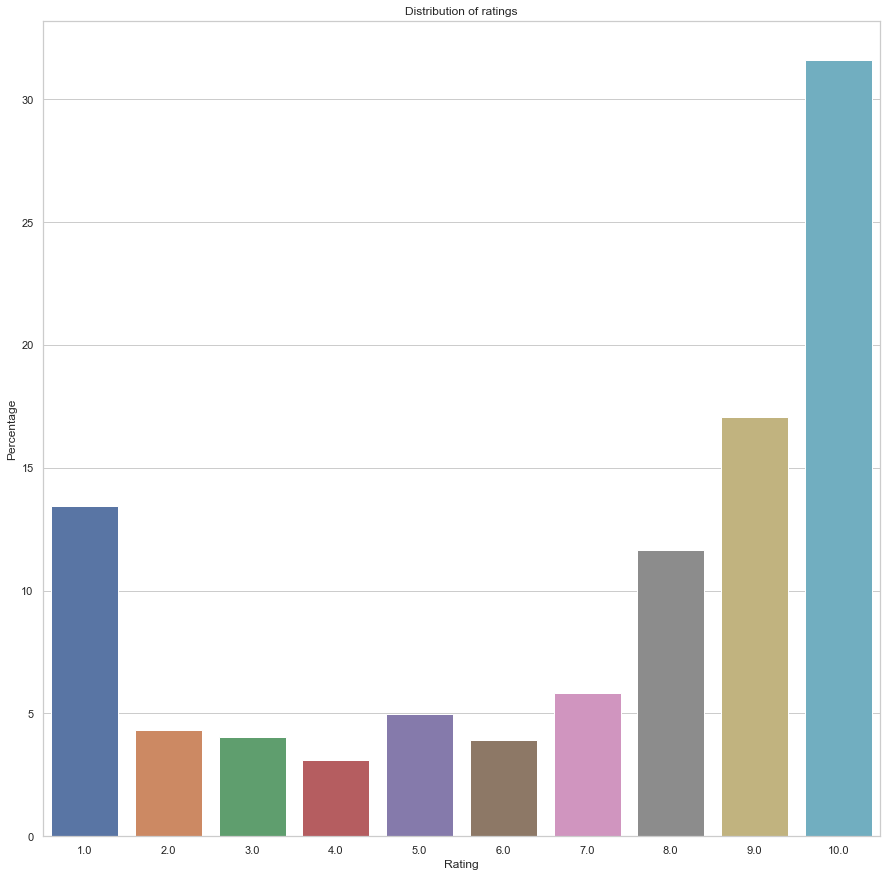

In [5]:
rating_count=df_drugs.groupby('rating').count()
# sns.distplot(pd.DataFrame(df_drugs.rating.value_counts())) #Fix histogram to show number of ratings vs rating value
df_drugs.rating.value_counts()

fig, ax = plt.subplots(figsize=(15, 15))

counts = df_drugs.rating.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xlabel('Rating')
ax.set_ylabel("Percentage")
ax.set_title('Distribution of ratings')

plt.show()

## Preprocessing

# Remove contradictory values? Positive sentiment with bad rating can be sarcasm etc etc 
When looking at some reviews, e.g.:

In [6]:
print(df_drugs.loc[3660,'review'])
# df_drugs.loc[221320,'review']

28lbs lost in 2.5 months using saxenda (dose between .6-1.2) &amp; following doctor&#039;s guidelines for eating.  Didn&#039;t exercise during the months. I was losing except for physical therapy 1x a week for back.  I&#039;m at a good weight for me (4&#039;11&quot;, 106, age 50) and have been maintaining within 2-4lbs for about 2 mos. now but still using saxenda.  Haven&#039;t been super strict with diet but not going crazy either.  Added light weight training and walking on treadmill 5-6 days a week right before Christmas.  If I overeat a day or 2 I go back to watching and the weight comes right back down.  Thankfully husband&#039;s insurance covers drug because mine doesn&#039;t.  Feel great, cholesterol &amp; blood pressure good again, back is better, and clothes fit.


It can be seen that some of the formatting of the file seems to be wrong, for example representing an apostrophe as "&#039;" or the ampersand as "&amp". The probable cause of this is that the dataset was loaded from HTML, which for example replaces an apostrophe with the previously mentioned value. This can be fixed replacing the values in the dataset with the correct format.

In [7]:
#Contractions removal, based on https://stackoverflow.com/a/47091490
import re   
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

unescaper = lambda x: decontracted(html.unescape(x))
df_drugs['review']=df_drugs['review'].apply(unescaper)

# df_drugs['review']=df_drugs['review'].apply(phrase())
print(df_drugs.loc[3660, 'review']) #If print is not used, jupyter changes the result and makes it unclear if everything worked ok



28lbs lost in 2.5 months using saxenda (dose between .6-1.2) & following doctor's guidelines for eating.  Did not exercise during the months. I was losing except for physical therapy 1x a week for back.  I am at a good weight for me (4'11", 106, age 50) and have been maintaining within 2-4lbs for about 2 mos. now but still using saxenda.  Have not been super strict with diet but not going crazy either.  Added light weight training and walking on treadmill 5-6 days a week right before Christmas.  If I overeat a day or 2 I go back to watching and the weight comes right back down.  Thankfully husband's insurance covers drug because mine does not.  Feel great, cholesterol & blood pressure good again, back is better, and clothes fit.


The reviews can then be tokenized and have the stop words removed, in order to filter out the data we are interested

In [8]:
#5 and 6 rating could be neutral, and 7 or more positive while 4 or less negative
def rating_labeler(val):
    if val>4:
        if val<7:
            lbl="Neutral"
        else:
            lbl="Positive"
    else:
        lbl="Negative"
    return lbl

df_drugs_labeled= df_drugs.copy()
df_drugs_labeled['rating_label'] = df_drugs_labeled['rating'].apply(lambda row: rating_labeler(row))
df_drugs_labeled.head(10)

,drugName,condition,review,rating,date,usefulCount,rating_label
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,Positive
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,Positive
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,Neutral
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,Positive
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,Positive
5,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2.0,"November 28, 2015",43,Negative
6,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1.0,"March 7, 2017",5,Negative
7,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10.0,"March 14, 2015",32,Positive
8,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1.0,"August 9, 2016",11,Negative
9,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8.0,"December 8, 2016",1,Positive


In [9]:
#Sentiment analysis
    
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()

def sentiment_analyzer_scores(sentence):
    score = sia.polarity_scores(sentence)
    return score
    
# sentiment_analyzer_scores(df_drugs.loc[20,'review'])

In [10]:
df_drugs_labeled['Compound_Score'] = df_drugs_labeled.apply(lambda row: sentiment_analyzer_scores(row['review'])['compound'], axis=1)
# df_drugs['Positive'] = df_drugs.apply(lambda row: sentiment_analyzer_scores(row['review'])['pos'], axis=1)
# df_drugs['Neutral'] = df_drugs.apply(lambda row: sentiment_analyzer_scores(row['review'])['neu'], axis=1)
# df_drugs['Negative'] = df_drugs.apply(lambda row: sentiment_analyzer_scores(row['review'])['neg'], axis=1)

#Labeler for multiclassification
def sentiment_labeler(val,limit):
    if val>limit:
        lbl='Positive'
    elif val<-limit:
        lbl='Negative'
    else:
        lbl='Neutral'
    return lbl

# df_drugs_labeled['Compound_Score'] = df_drugs_labeled['Compound']
df_drugs_labeled['Compound_label'] = df_drugs_labeled['Compound_Score'].apply(lambda row: sentiment_labeler(row,0.3))

In [11]:
df_drugs_labeled.head(20)
#Results seem weird...

,drugName,condition,review,rating,date,usefulCount,rating_label,Compound_Score,Compound_label
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,Positive,-0.2960,Neutral
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,Positive,0.9174,Positive
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,Neutral,0.6387,Positive
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,Positive,0.7184,Positive
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,Positive,0.9403,Positive
5,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2.0,"November 28, 2015",43,Negative,-0.8972,Negative
6,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1.0,"March 7, 2017",5,Negative,0.0000,Neutral
7,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10.0,"March 14, 2015",32,Positive,-0.9468,Negative
8,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1.0,"August 9, 2016",11,Negative,-0.5593,Negative
9,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8.0,"December 8, 2016",1,Positive,-0.9010,Negative


In [12]:
print(df_drugs_labeled.loc[7, 'review'])

Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage. My moods were out of control. I was depressed and hopeless one second and then mean, irrational, and full of rage the next. My Dr. prescribed me 2mg of Abilify and from that point on I feel like I have been cured though I know I am not.. Bi-polar disorder is a constant battle. I know Abilify works for me because I have tried to get off it and lost complete control over my emotions. Went back on it and I was golden again.  I am on 5mg 2x daily. I am now 21 and better than I have ever been in the past. Only side effect is I like to eat a lot.


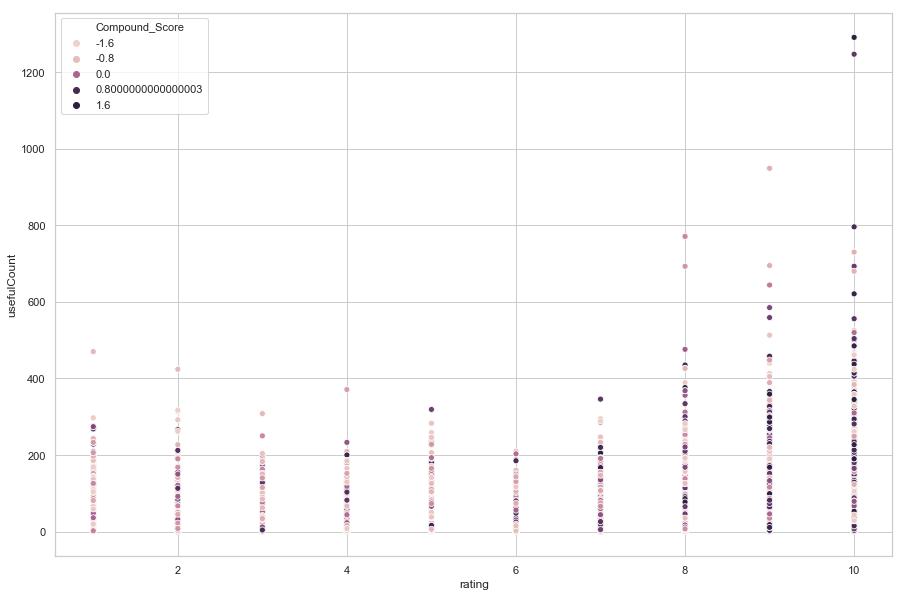

In [13]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = df_drugs_labeled, x = 'rating', y = 'usefulCount', hue = 'Compound_Score')

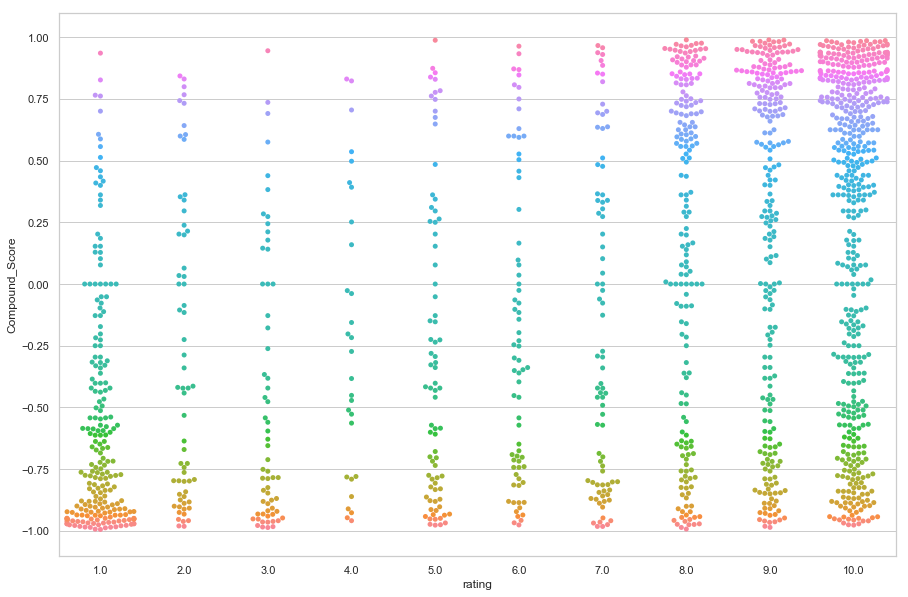

In [14]:
plt.figure(figsize=(15,10))
ax = sns.swarmplot(x = 'rating', y='Compound_Score', data = df_drugs_labeled.sample(n=1500),
                   hue = 'Compound_Score')
ax.legend_.remove()

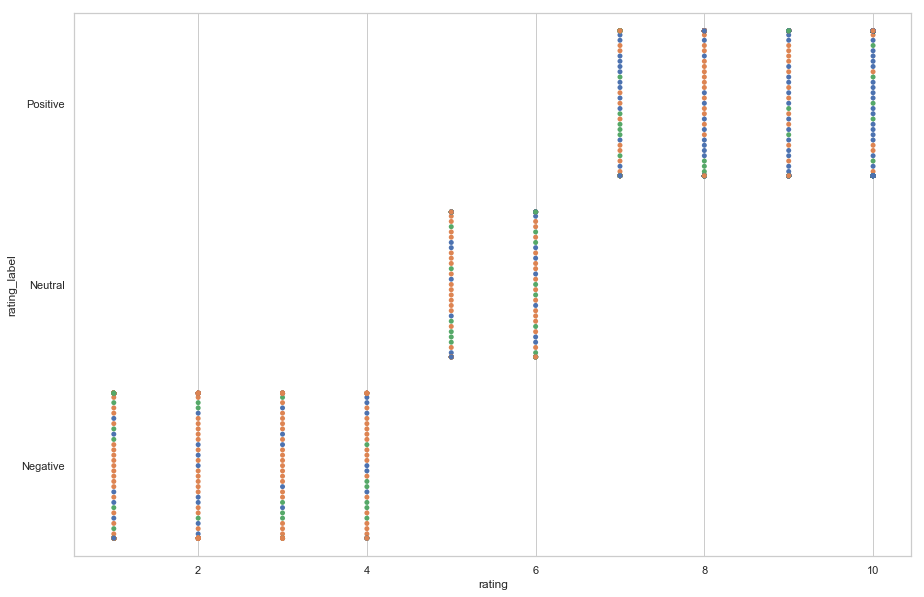

In [15]:
plt.figure(figsize=(15,10))
ax = sns.swarmplot(x = 'rating', y='rating_label', data = df_drugs_labeled.sample(n=1500),
                   hue = 'Compound_label', order=['Positive', 'Neutral', 'Negative'])
ax.legend_.remove()

Wordcloud taking into account all of the reviews:

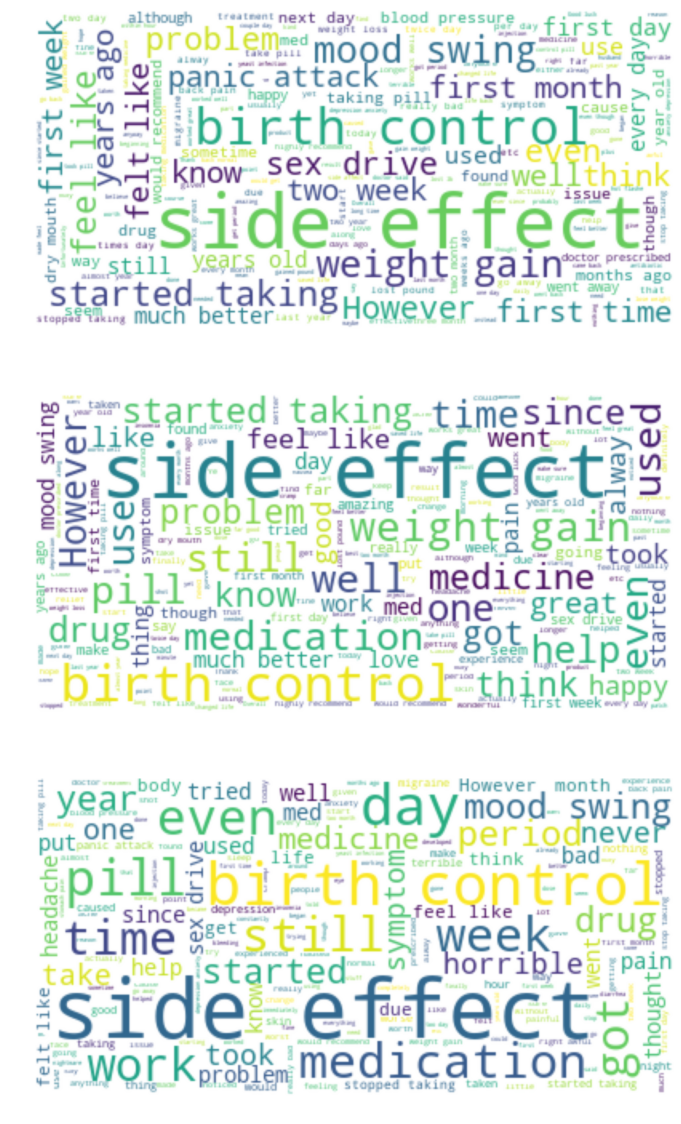

In [29]:
#Wordcloud, based on https://www.datacamp.com/community/tutorials/wordcloud-python
from nltk.corpus import stopwords

def wordClouder(review_txt):
    text = " ".join(review for review in review_txt)

    # Create stopword list:
    stop_words = set(stopwords.words('english')) 
    stop_words.update(["also"])

    # Generate a word cloud image
    wc = WordCloud(stopwords = stop_words, background_color="white").generate(text)
    return wc

#Vader sentiment classifier binarization as positive and negative
df_drugs_positive=df_drugs_labeled[df_drugs_labeled['rating_label']=='Positive']
df_drugs_positive=df_drugs_positive[df_drugs_positive['Compound_Score']>0.5]

df_drugs_negative=df_drugs_labeled[df_drugs_labeled['rating_label']=='Negative']
df_drugs_negative=df_drugs_negative[df_drugs_negative['Compound_Score']<-0.5]


fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20, 20))
ax1.imshow(wordClouder(df_drugs_labeled.review), interpolation='gaussian')
ax1.set_axis_off()
#Positive reviews
ax2.imshow(wordClouder(df_drugs_positive['review']), interpolation='gaussian')
ax2.set_axis_off()
#Negative reviews
ax3.imshow(wordClouder(df_drugs_negative['review']), interpolation='gaussian')
ax3.set_axis_off()

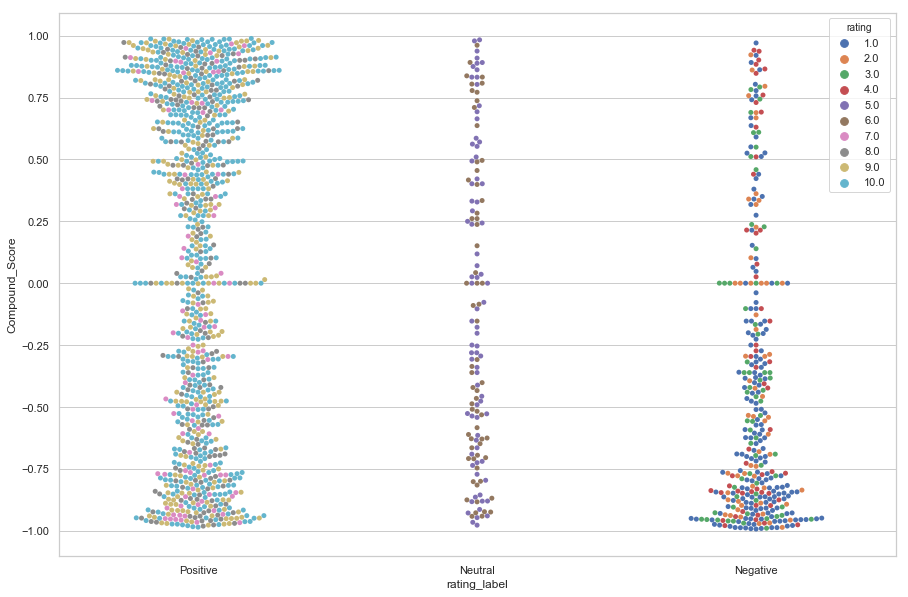

In [28]:
plt.figure(figsize=(15,10))
ax = sns.swarmplot(x = 'rating_label', y='Compound_Score', data = df_drugs_labeled.sample(n=1500),
                   hue = 'rating', order=['Positive','Neutral','Negative'])